In [183]:
import os
import json
import math
import rasterio
from rasterio.plot import reshape_as_image
import rasterio.mask
from rasterio.features import rasterize
import matplotlib
import matplotlib.pyplot as plt
import cv2
import pandas as pd
import geopandas as gpd
from shapely.geometry import mapping, Point, Polygon
from shapely.ops import cascaded_union
import numpy as np
import PIL
import matplotlib.pyplot as plt


# Création d'un masque à partir du GeoJson et d'une liste de features

- Cette version traite une image à la fois. 
**V2 possible: prendre en entrée un fichier texte contenant les noms des cartes à traiter**
- On considère une liste donnée de feattypes donnée plus bas
- Le masque en sortie est un png de la même taille que le GeoTIFF en entrée, codé sur un canal 8 bits
- Si un pixel appartient à au moins deux objets, il prend la valeur de pixel somme 
**V2 possible: donner une règle de priorité entre les types d'objet: qui passe devant qui ? ex runway marking devant runwayelement.**


In [184]:
# A MODIFIER AVEC LES BONS CHEMINS POUR RUN LE CODE SUR VOTRE MACHINE

path_GeoTIFF = "/Users/salimbaddou/PIE/Airport_Feature_Auto_Detection/GeoTIFF/"
path_GeoJson = "/Users/salimbaddou/PIE/Airport_Feature_Auto_Detection/GeoJson/"

#image considérée
name_map = "VHHH"

#chemin de sortie pour le masque png
outfolder = "/Users/salimbaddou/PIE"  
os.makedirs(outfolder, exist_ok=True)

In [201]:
# Liste des features d'intérêt et color mapping (1 canal nuances de gris de 1 à 255, 0 est background)
color_mapping = {
    'Apron.apronelement': 50,
    'Runway.runwayelement': 100,
    'ServiceRoad.serviceroad': 150,
}
features_list = ['Apron.apronelement','Runway.runwayelement','ServiceRoad.serviceroad']

In [205]:
# Fonctions de création de masques par lecture du GeoJson
# TO DO: V2 qui gère la superposition d'objets. Idée: un petit objet inclut dans un autre doit avoir priorité sur l'affichage 

def poly_from_utm(polygon, transform):
    poly_pts = []
    
    # make a polygon from multipolygon
    poly = cascaded_union(polygon)
    for i in np.array(poly.exterior.coords):
        
        # transfrom polygon to image crs, using raster meta
        poly_pts.append(~transform * tuple(i))
        
    # make a shapely Polygon object
    new_poly = Polygon(poly_pts)
    return new_poly

# creating binary mask for field/not_filed segmentation.
def create_mask(features_list,src,df):
    nb_class=len(features_list)
    im_size = (src.meta['height'], src.meta['width'])
    whole_mask = np.zeros([src.meta['height'],src.meta['width']])

    for i,f in enumerate(features_list):
        poly_shp = []
        data_geom = df[df['feattype'] == {'value': f}].geometry
        for g in data_geom.values:

            poly = poly_from_utm(g, src.meta['transform'])
            poly_shp.append(poly)

            if g.geom_type == 'Polygon':
                poly = poly_from_utm(g, src.meta['transform'])
                poly_shp.append(poly)
            else:
                for p in g:
                    poly = poly_from_utm(p, src.meta['transform'])
                    poly_shp.append(poly)
        if poly_shp:
            mask = rasterize(shapes=poly_shp,out_shape=im_size)*color_mapping[f]
            #print(mask.shape)
            whole_mask = whole_mask + mask
           
    return whole_mask

def create_mask_multi_channel(features_list,src,df):
    nb_class=len(features_list)
    im_size = (src.meta['height'], src.meta['width'])
    whole_mask = np.zeros([src.meta['height'],src.meta['width'],nb_class])

    for i,f in enumerate(features_list):
        poly_shp = []
        data_geom = df[df['feattype'] == {'value': f}].geometry
        for g in data_geom.values:

            poly = poly_from_utm(g, src.meta['transform'])
            poly_shp.append(poly)

            if g.geom_type == 'Polygon':
                poly = poly_from_utm(g, src.meta['transform'])
                poly_shp.append(poly)
            else:
                for p in g:
                    poly = poly_from_utm(p, src.meta['transform'])
                    poly_shp.append(poly)
        if poly_shp:
            mask = rasterize(shapes=poly_shp,out_shape=im_size)*color_mapping[f]
            #print(mask.shape)
            whole_mask[:,:,i] = mask
           
    return whole_mask


In [206]:
img_name = name_map+"_ortho.tif"
directory = os.fsencode(path_GeoTIFF)

for file in os.listdir(directory):
    
    filename = os.fsdecode(file)
    if filename==img_name:
        with rasterio.open(path_GeoTIFF+"{}".format(filename)) as src:
            img = src.read()
            meta = src.meta
            filepath = path_GeoJson+"product_ADBLucem_"+name_map+".json"
            df = polygon_df(filepath)
            
            whole_mask = create_mask_multi_channel(features_list,src,df)
            
        
            
            print(whole_mask.shape)
            
#             #Rescale to 0-255 and convert to uint8
#             rescaled = (255.0 / data.max() * (data - data.min())).astype(np.uint8)

            # Save numpy array into png mask 1 channel
            cv2.imwrite(outfolder + '/masktest4_{}.png'.format(img_name.split('_')[0]),whole_mask)


(12700, 19699, 3)


In [181]:
def crop_img_mask(filename):
    name = "LIRP" + str(np.random.randint(1,5000))
    print(name)
    with rasterio.open("/Users/salimbaddou/PIE/Airport_Feature_Auto_Detection/GeoTIFF/{}_ortho.tif".format(filename)) as src:
        img = src.read()
    _,xs,ys = img.shape
    i = np.random.randint(1,100)
    i = i*10
    
    im_size = 512
    cut = np.random.randint(1,im_size - 30)
    
    
    
    #img = reshape_as_image(img):,i:i+im_size,j:j+im_size])
    img = reshape_as_image(img)
    img = img[4000 - i :5000- i,1000 + i:2001+ i]
    
    img = img[cut:cut+im_size,cut:cut+im_size]
    #print(img.shape)
    plt.imshow(img)
    
    
    matplotlib.image.imsave('/Users/salimbaddou/PIE/data2/imgs/{}.png'.format(name), img)
    
    
    with rasterio.open("/Users/salimbaddou/PIE/masktest_{}.png".format(filename)) as src:
        img = src.read()
        
    #print(img.shape)
        
    img = img[0,4000 - i :5000- i,1000 + i:2001+ i]
    img = img[cut:cut+im_size,cut:cut+im_size]
    #img =img[0,i:i+im_size,j:j+im_size]
    #img = img[0,i:i+500,i:i+500]
    print(img.shape)
    plt.imshow(img)
    
    cv2.imwrite('/Users/salimbaddou/PIE/data2/masks/{}.png'.format(name), img)
    
    
    

LIRP583
(512, 512)
LIRP4919
(512, 512)
LIRP2587
(512, 512)
LIRP2146


KeyboardInterrupt: 

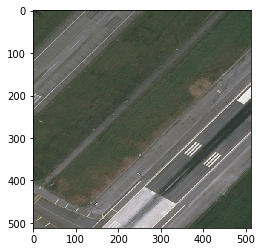

In [182]:
for i in range(90):
    crop_img_mask("LIRP")

In [ ]:
#crop loi normale

In [198]:
def crop_img_mask(filename):
    name = "VHHH" + str(np.random.randint(1,10000))
    print(name)
    with rasterio.open("/Users/salimbaddou/PIE/Airport_Feature_Auto_Detection/GeoTIFF/{}_ortho.tif".format(filename)) as src:
        img = src.read()
    _,xs,ys = img.shape
    mean = (xs//2, ys//2)
    cov = [[100*xs, 0], [0, 100*ys]]
    x = np.random.multivariate_normal(mean, cov)
    print(int(x[0]))
    im_size = 512
    
    
    img = reshape_as_image(img)
    
    
    img = img[int(x[0]):int(x[0])+im_size,int(x[1]):int(x[1])+im_size]
    #print(img.shape)
    plt.imshow(img)
    
    
    matplotlib.image.imsave('/Users/salimbaddou/PIE/data2/imgs/{}.png'.format(name), img)
    
    
    with rasterio.open("/Users/salimbaddou/PIE/masktest3_{}.png".format(filename)) as src:
        img = src.read()
        
    
    print(img.shape)
    img = reshape_as_image(img)
    print(img.shape)
    img = img[int(x[0]):int(x[0])+im_size,int(x[1]):int(x[1])+im_size,0]
    
    print(img.shape)
    plt.imshow(img)
    
    cv2.imwrite('/Users/salimbaddou/PIE/data2/masks/{}.png'.format(name), img)
    
    
    

VHHH9144
7716
(1, 12700, 19699)
(12700, 19699, 1)
(512, 512)
VHHH3662
6361
(1, 12700, 19699)
(12700, 19699, 1)
(512, 512)
VHHH6617
6020
(1, 12700, 19699)
(12700, 19699, 1)
(512, 512)
VHHH9428
5037
(1, 12700, 19699)
(12700, 19699, 1)
(512, 512)
VHHH2948
7106
(1, 12700, 19699)
(12700, 19699, 1)
(512, 512)
VHHH8385
7106
(1, 12700, 19699)
(12700, 19699, 1)
(512, 512)
VHHH893
6509
(1, 12700, 19699)
(12700, 19699, 1)
(512, 512)
VHHH6841
5413
(1, 12700, 19699)
(12700, 19699, 1)
(512, 512)
VHHH6338
7896
(1, 12700, 19699)
(12700, 19699, 1)
(512, 512)
VHHH9592
6395
(1, 12700, 19699)
(12700, 19699, 1)
(512, 512)
VHHH6379
7195
(1, 12700, 19699)
(12700, 19699, 1)
(512, 512)
VHHH46
4985
(1, 12700, 19699)
(12700, 19699, 1)
(512, 512)
VHHH2485
7699
(1, 12700, 19699)
(12700, 19699, 1)
(512, 512)
VHHH1917
4087
(1, 12700, 19699)
(12700, 19699, 1)
(512, 512)
VHHH4008
4907
(1, 12700, 19699)
(12700, 19699, 1)
(512, 512)
VHHH7682
5317
(1, 12700, 19699)
(12700, 19699, 1)
(512, 512)
VHHH2052
5217
(1, 12700, 19

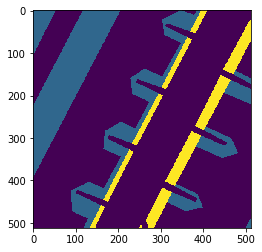

In [199]:
for i in range(90):
    crop_img_mask("VHHH")

# OLD: exploration et manipulation d'un GeoJson

### Open image with rasterio:

In [9]:
with rasterio.open(path_GeoTIFF+"/"+name_map+"_ortho.tif") as src:
    img = src.read()
    meta = src.meta

img = reshape_as_image(img)



### Read Geojson as  a dataframe:

In [10]:
def polygon_df(filepath):
    df = gpd.read_file(filepath)
    df = df.drop(columns=['originated', 'readonly',
           'notvalidated', 'lock', 'elev', 'hacc', 'iata', 'name', 'idarpt',
           'acft', 'idnumber', 'termref', 'pcn', 'restacft', 'status', 'surftype',
           'length', 'width', 'color', 'direc', 'style', 'rwymktyp', 'asda',
           'availPavedSurfFromThr', 'brngmag', 'brngtrue', 'cat', 'ellipse',
           'geound', 'lda', 'rops_landing_length', 'rwyslope', 'tdze', 'tdzslope',
           'thrtype', 'toda', 'tora', 'vasis', 'bridge', 'gsurftyp', 'runwayexit',
           'imagery_date'])
    
    return df[df["geometry"].geom_type == 'Polygon']

#### Only polygon:

In [11]:
df = polygon_df(path_GeoJson+"/product_ADBLucem_"+name_map+".json")
df.head()

,id,feattype,label_id,name_id,geometry
41,ALLADB|ADBLucem|runwaydisplacedarea|8074,{'value': 'Runway.runwaydisplacedarea'},{'value': '04L'},{'value': '04L'},"POLYGON ((10.38092 43.67440, 10.38137 43.67415..."
42,ALLADB|ADBLucem|runwaydisplacedarea|8075,{'value': 'Runway.runwaydisplacedarea'},{'value': '22L'},{'value': '22L'},"POLYGON ((10.40381 43.69270, 10.40570 43.69453..."
43,ALLADB|ADBLucem|runwaydisplacedarea|8076,{'value': 'Runway.runwaydisplacedarea'},{'value': '04R'},{'value': '04R'},"POLYGON ((10.38345 43.67297, 10.38450 43.67398..."
44,ALLADB|ADBLucem|runwayelement|12752,{'value': 'Runway.runwayelement'},{'value': '04L/22R'},{'value': '04L/22R'},"POLYGON ((10.38314 43.67587, 10.38998 43.68250..."
45,ALLADB|ADBLucem|runwayelement|12753,{'value': 'Runway.runwayelement'},{'value': '04R/22L'},{'value': '04R/22L'},"POLYGON ((10.38450 43.67398, 10.40381 43.69270..."


### Liste des features contenues dans le GeoJSON

In [12]:
features_list = []
for e in df['feattype']:
    if e['value'] not in features_list:
        features_list.append(e['value'])

print(features_list)

['Runway.runwaydisplacedarea', 'Runway.runwayelement', 'Runway.runwaymarking', '0']


In [196]:
np.unique(np.array(PIL.Image.open("/Users/salimbaddou/PIE/masktest3_VHHH.png")))

DecompressionBombError: Image size (250177300 pixels) exceeds limit of 178956970 pixels, could be decompression bomb DOS attack.

In [197]:
with rasterio.open("/Users/salimbaddou/PIE/masktest3_VHHH.png") as src:
    img = src.read()
 

print(np.unique(np.array(img)))

[0 1 2 3 4]
